In [3]:
%pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn tf_keras matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="Capstone_Weeds")

dataset.push_to_hub("n1hal/Capstone_Weeds")

Resolving data files:   0%|          | 0/72003 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/8001 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20002 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/36002 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/361 [00:00<?, ?ba/s]

Map:   0%|          | 0/36001 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/361 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/8001 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/81 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/20002 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/201 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/n1hal/Capstone_Weeds/commit/a9da38883d58a5a6da388e98ba520d468e2e4ba0', commit_message='Upload dataset', commit_description='', oid='a9da38883d58a5a6da388e98ba520d468e2e4ba0', pr_url=None, pr_revision=None, pr_num=None)

In [6]:
from datasets import load_dataset

weeds = load_dataset("n1hal/Capstone_Weeds")

Generating train split:   0%|          | 0/72003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8001 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20002 [00:00<?, ? examples/s]

In [7]:
# weeds = weeds.train_test_split(test_size=0.2)

In [8]:
weeds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 72003
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 8001
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 20002
    })
})

In [47]:
weeds["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 72003
})

In [10]:
labels = weeds["train"].features["label"].names
label2id, id2label = dict(), dict()

In [11]:
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [12]:
# id2label[str(79)]

In [13]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

2024-07-30 21:36:06.787985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 21:36:06.857481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 21:36:06.872114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 21:36:06.958856: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 21:36:08.081890: W tensorflow/compiler/tf2

In [14]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])


In [15]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [16]:
weeds = weeds.with_transform(transforms)

In [17]:
weeds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 72003
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 8001
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 20002
    })
})

In [18]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [19]:
import evaluate

accuracy = evaluate.load("accuracy")

In [20]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return accuracy.compute(predictions=predictions, references = labels)

In [21]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
training_args = TrainingArguments(
    output_dir = "Weeds_Classification",
    remove_unused_columns = False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 5e-5,
    per_device_train_batch_size = 16,
    gradient_accumulation_steps = 4,
    num_train_epochs = 3,
    warmup_ratio = 0.1,
    logging_steps = 10,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    push_to_hub = True,
)

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = weeds["train"],
    eval_dataset = weeds["validation"],
    tokenizer = image_processor,
    compute_metrics = compute_metrics,
)

/home/nihaltm/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
trainer.train()

  0%|          | 0/3375 [00:00<?, ?it/s]

{'loss': 5.8294, 'grad_norm': 0.9497740864753723, 'learning_rate': 1.4792899408284024e-06, 'epoch': 0.01}
{'loss': 5.8243, 'grad_norm': 0.9087894558906555, 'learning_rate': 2.9585798816568047e-06, 'epoch': 0.02}
{'loss': 5.827, 'grad_norm': 0.9352946877479553, 'learning_rate': 4.437869822485207e-06, 'epoch': 0.03}
{'loss': 5.8183, 'grad_norm': 0.9707036018371582, 'learning_rate': 5.917159763313609e-06, 'epoch': 0.04}
{'loss': 5.8326, 'grad_norm': 0.9326181411743164, 'learning_rate': 7.396449704142013e-06, 'epoch': 0.04}
{'loss': 5.8168, 'grad_norm': 0.9484497308731079, 'learning_rate': 8.875739644970414e-06, 'epoch': 0.05}
{'loss': 5.8207, 'grad_norm': 0.9521200656890869, 'learning_rate': 1.0355029585798817e-05, 'epoch': 0.06}
{'loss': 5.817, 'grad_norm': 0.8906506896018982, 'learning_rate': 1.1834319526627219e-05, 'epoch': 0.07}
{'loss': 5.8186, 'grad_norm': 0.995785117149353, 'learning_rate': 1.3313609467455624e-05, 'epoch': 0.08}
{'loss': 5.8132, 'grad_norm': 0.9234928488731384, 'le

  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 4.957149982452393, 'eval_accuracy': 0.2169728783902012, 'eval_runtime': 76.0873, 'eval_samples_per_second': 105.156, 'eval_steps_per_second': 13.156, 'epoch': 1.0}
{'loss': 4.8993, 'grad_norm': 1.3653733730316162, 'learning_rate': 3.696081659532433e-05, 'epoch': 1.0}
{'loss': 4.8834, 'grad_norm': 1.4774038791656494, 'learning_rate': 3.6796180441224894e-05, 'epoch': 1.01}
{'loss': 4.9007, 'grad_norm': 1.4379853010177612, 'learning_rate': 3.663154428712545e-05, 'epoch': 1.02}
{'loss': 4.8714, 'grad_norm': 1.4435831308364868, 'learning_rate': 3.646690813302601e-05, 'epoch': 1.03}
{'loss': 4.9021, 'grad_norm': 1.6181260347366333, 'learning_rate': 3.630227197892657e-05, 'epoch': 1.04}
{'loss': 4.9192, 'grad_norm': 1.494800090789795, 'learning_rate': 3.613763582482713e-05, 'epoch': 1.05}
{'loss': 4.8974, 'grad_norm': 2.6939356327056885, 'learning_rate': 3.5972999670727694e-05, 'epoch': 1.06}
{'loss': 4.963, 'grad_norm': 1.4140138626098633, 'learning_rate': 3.580836351662825e-05

  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 4.412487506866455, 'eval_accuracy': 0.2583427071616048, 'eval_runtime': 88.7081, 'eval_samples_per_second': 90.195, 'eval_steps_per_second': 11.284, 'epoch': 2.0}
{'loss': 4.2468, 'grad_norm': 1.8213180303573608, 'learning_rate': 1.8356931182087586e-05, 'epoch': 2.01}
{'loss': 4.3523, 'grad_norm': 2.8117318153381348, 'learning_rate': 1.8192295027988145e-05, 'epoch': 2.02}
{'loss': 4.3152, 'grad_norm': 1.7463642358779907, 'learning_rate': 1.8027658873888705e-05, 'epoch': 2.03}
{'loss': 4.3509, 'grad_norm': 1.9505913257598877, 'learning_rate': 1.7863022719789264e-05, 'epoch': 2.04}
{'loss': 4.2851, 'grad_norm': 2.282400369644165, 'learning_rate': 1.7698386565689827e-05, 'epoch': 2.04}
{'loss': 4.2536, 'grad_norm': 2.147862195968628, 'learning_rate': 1.7533750411590387e-05, 'epoch': 2.05}
{'loss': 4.3518, 'grad_norm': 2.477461099624634, 'learning_rate': 1.7369114257490946e-05, 'epoch': 2.06}
{'loss': 4.3363, 'grad_norm': 1.6753101348876953, 'learning_rate': 1.720447810339150

  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 4.227635860443115, 'eval_accuracy': 0.27546556680414946, 'eval_runtime': 76.5679, 'eval_samples_per_second': 104.495, 'eval_steps_per_second': 13.073, 'epoch': 3.0}
{'train_runtime': 6798.0282, 'train_samples_per_second': 31.775, 'train_steps_per_second': 0.496, 'train_loss': 4.755938376532661, 'epoch': 3.0}


TrainOutput(global_step=3375, training_loss=4.755938376532661, metrics={'train_runtime': 6798.0282, 'train_samples_per_second': 31.775, 'train_steps_per_second': 0.496, 'total_flos': 1.678650555446478e+19, 'train_loss': 4.755938376532661, 'epoch': 2.9993334814485673})

In [24]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/n1hal/Weeds_Classification/commit/39a05bb9fc461265eb4e7d40d2a9ef2560e55299', commit_message='End of training', commit_description='', oid='39a05bb9fc461265eb4e7d40d2a9ef2560e55299', pr_url=None, pr_revision=None, pr_num=None)

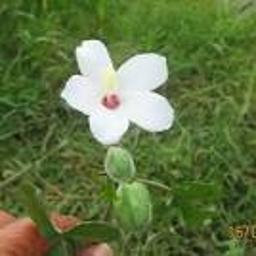

In [25]:
ds = load_dataset("n1hal/Capstone_Weeds", split="validation")
image = ds["image"][0]
image

In [26]:
from transformers import pipeline

classifier = pipeline("image-classification", model="Weeds_Classification", device=0)
classifier(image)

[{'label': 'Abelmoschus moschatus Medik.', 'score': 0.9511571526527405},
 {'label': 'Abelmoschus ficulneus L. Wight Arn.', 'score': 0.9086750149726868},
 {'label': 'Hibiscus vitifolius Linn.', 'score': 0.8956620097160339},
 {'label': 'Urena lobata L.', 'score': 0.8885037899017334},
 {'label': 'Hibiscus panduriformis Burm. f.', 'score': 0.887142539024353}]

In [27]:
len(labels)

337

In [28]:
trainer.evaluate()

  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 4.233978748321533,
 'eval_accuracy': 0.27034120734908135,
 'eval_runtime': 95.2531,
 'eval_samples_per_second': 83.997,
 'eval_steps_per_second': 10.509,
 'epoch': 2.9993334814485673}

In [29]:
trainer.state.log_history

[{'loss': 5.8294,
  'grad_norm': 0.9497740864753723,
  'learning_rate': 1.4792899408284024e-06,
  'epoch': 0.008886914019106865,
  'step': 10},
 {'loss': 5.8243,
  'grad_norm': 0.9087894558906555,
  'learning_rate': 2.9585798816568047e-06,
  'epoch': 0.01777382803821373,
  'step': 20},
 {'loss': 5.827,
  'grad_norm': 0.9352946877479553,
  'learning_rate': 4.437869822485207e-06,
  'epoch': 0.026660742057320594,
  'step': 30},
 {'loss': 5.8183,
  'grad_norm': 0.9707036018371582,
  'learning_rate': 5.917159763313609e-06,
  'epoch': 0.03554765607642746,
  'step': 40},
 {'loss': 5.8326,
  'grad_norm': 0.9326181411743164,
  'learning_rate': 7.396449704142013e-06,
  'epoch': 0.04443457009553432,
  'step': 50},
 {'loss': 5.8168,
  'grad_norm': 0.9484497308731079,
  'learning_rate': 8.875739644970414e-06,
  'epoch': 0.05332148411464119,
  'step': 60},
 {'loss': 5.8207,
  'grad_norm': 0.9521200656890869,
  'learning_rate': 1.0355029585798817e-05,
  'epoch': 0.06220839813374806,
  'step': 70},
 {

In [30]:
[print(x["loss"] for x in trainer.state.log_history)]

<generator object <genexpr> at 0x7fe3ef2c5040>


[None]

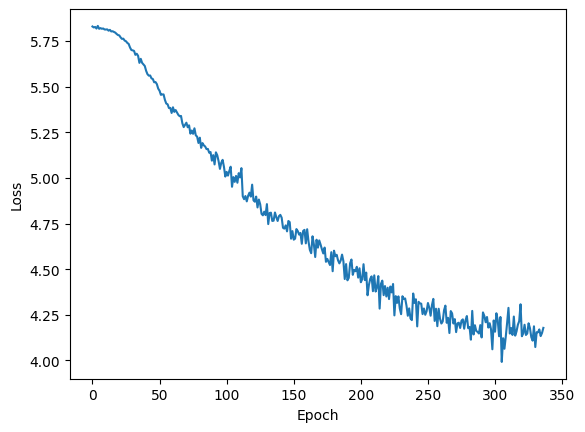

In [31]:
# Plotting the increase in accracy over time
import matplotlib.pyplot as plt

losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [32]:
image = weeds["validation"]

In [33]:
image[0]

{'label': 0,
 'pixel_values': tensor([[[-0.4980, -0.5216, -0.5686,  ..., -0.1451, -0.1686, -0.2078],
          [-0.4745, -0.4980, -0.5451,  ..., -0.1686, -0.2078, -0.2314],
          [-0.4510, -0.4745, -0.5294,  ..., -0.2000, -0.2392, -0.2627],
          ...,
          [-0.3176, -0.3098, -0.2941,  ..., -0.4980, -0.5137, -0.5059],
          [-0.3098, -0.3020, -0.2863,  ..., -0.5216, -0.5373, -0.5373],
          [-0.3176, -0.3098, -0.3020,  ..., -0.5451, -0.5765, -0.5843]],
 
         [[-0.2627, -0.2863, -0.3176,  ...,  0.1686,  0.1451,  0.1059],
          [-0.2392, -0.2627, -0.3020,  ...,  0.1451,  0.1059,  0.0824],
          [-0.2157, -0.2392, -0.2863,  ...,  0.1137,  0.0745,  0.0510],
          ...,
          [-0.1922, -0.1843, -0.1686,  ..., -0.2863, -0.2941, -0.2941],
          [-0.1922, -0.1843, -0.1686,  ..., -0.3098, -0.3255, -0.3412],
          [-0.2000, -0.1922, -0.1843,  ..., -0.3333, -0.3647, -0.3882]],
 
         [[-0.7333, -0.7569, -0.8039,  ..., -0.5294, -0.5529, -0.5922],

In [38]:
ds = load_dataset("n1hal/Capstone_Weeds", split="validation[:10]")
image = ds["image"][0]

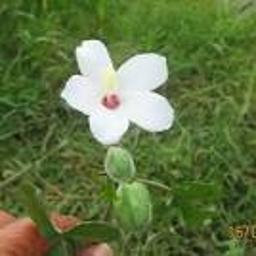

In [39]:
image

In [44]:
ds["label"]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [36]:
from transformers import pipeline

classifier = pipeline("image-classification", model = "Weeds_Classification")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [37]:
classifier(image)

[{'label': 'Brachiaria eruciformis J.E.Smith Griseb.',
  'score': 0.7283827066421509},
 {'label': 'Asteracantha longifolia L. Nees.', 'score': 0.7247171401977539},
 {'label': 'Volutarella divaricata Benth  Hook.', 'score': 0.7182118892669678},
 {'label': 'Convolvulus pluricaulis Choisy.', 'score': 0.7177550792694092},
 {'label': 'Sebastiana chamaelea Linn. Muell.', 'score': 0.7168266773223877}]